In [1]:
import os
from tqdm.notebook import tqdm
from deepmusic import MusicRepr, Constants
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import pickle
import seaborn as sns

tqdm.pandas()

# LMD-matched dataset

In [6]:
const = Constants(unit=4, num_tempo_bins=20, num_velocity_bins=20)
path = '/home/soroosh/data/MIDI/LMD-Matched/lmd_processed/'
files = list(filter(lambda x: x.endswith('.mid'), os.listdir(path)))
len(files)

22945

In [54]:
def process_file(file):
    seq = MusicRepr.from_file(path + file, const=const)
    tracks = seq.separate_tracks()
    ent = {'file' : file, 'n_bar': seq.get_bar_count()}
    for inst in const.instruments:
        if inst in tracks:
            ent[inst] = len(tracks[inst])
        else:
            ent[inst] = 0
    return ent
    
res = Parallel(n_jobs=20)(delayed(process_file)(file) for file in tqdm(files))

In [174]:
df = pd.DataFrame(res)
df = df.sort_values('n_bar').reset_index(drop=True)
df.head()

,file,n_bar,piano,percussion,organ,guitar,bass,strings,ensemble,brass,...,pipe,synth-lead,synth-pad,synth-effects,ethnic,percussive,sound-effects,drums,genre,style
0,9ceb6e6904becc8c2a75fe0c3a37657f.mid,453,0,0,0,1247,6407,1070,4331,2475,...,790,0,0,0,0,0,0,0,,
1,22a6ad62aebeb0612700f64d02dc18ec.mid,443,0,0,0,0,0,1178,11786,1540,...,1734,0,0,0,0,0,0,0,,
2,4fb43d0e8e8d263a5c97a797d8343a08.mid,405,7954,5133,0,4696,3553,0,0,0,...,0,0,4383,0,0,0,0,9507,,
3,a595d0ca98ca67de51306436cf23efae.mid,401,0,0,0,0,0,2648,10026,1090,...,1626,0,0,0,0,0,0,0,,
4,934b2b590e68fb5c6b7ea99b8292af51.mid,400,0,0,0,0,0,0,11299,1119,...,1610,0,0,0,0,0,0,0,,


In [3]:
# df.to_csv('lmd_data.csv', index=False)
df = pd.read_csv('lmd_data.csv')

In [176]:
# f = open('/home/soroosh/data/MIDI/LMD-Matched/msd-MAGD-genreAssignment.cls')
# s = f.read().strip().split('\n')
# f.close()
# print(len(s))

# genre_map = {}
# for l in s:
#     a,b = l.split('\t')
#     genre_map[a] = b
    
# f = open('/home/soroosh/data/MIDI/LMD-Matched/msd-MASD-styleAssignment.cls')
# s = f.read().strip().split('\n')
# f.close()
# print(len(s))

# style_map = {}
# for l in s:
#     a,b = l.split('\t')
#     style_map[a] = b
    
# f = open('/home/soroosh/data/MIDI/LMD-Matched/file_paths.txt')
# s = f.read().strip().split('\n')
# f.close()
# print(len(s))

# hash_map = {}
# for l in s:
#     a,b = l.split('/')[-2:]
#     hash_map[b] = a
    
# print(len(set(style_map).intersection(set(genre_map))))

In [177]:
# df['genre'] = df['file'].apply(lambda x: genre_map[hash_map[x]] if hash_map[x] in genre_map else '')
# df['style'] = df['file'].apply(lambda x: style_map[hash_map[x]] if hash_map[x] in style_map else '')

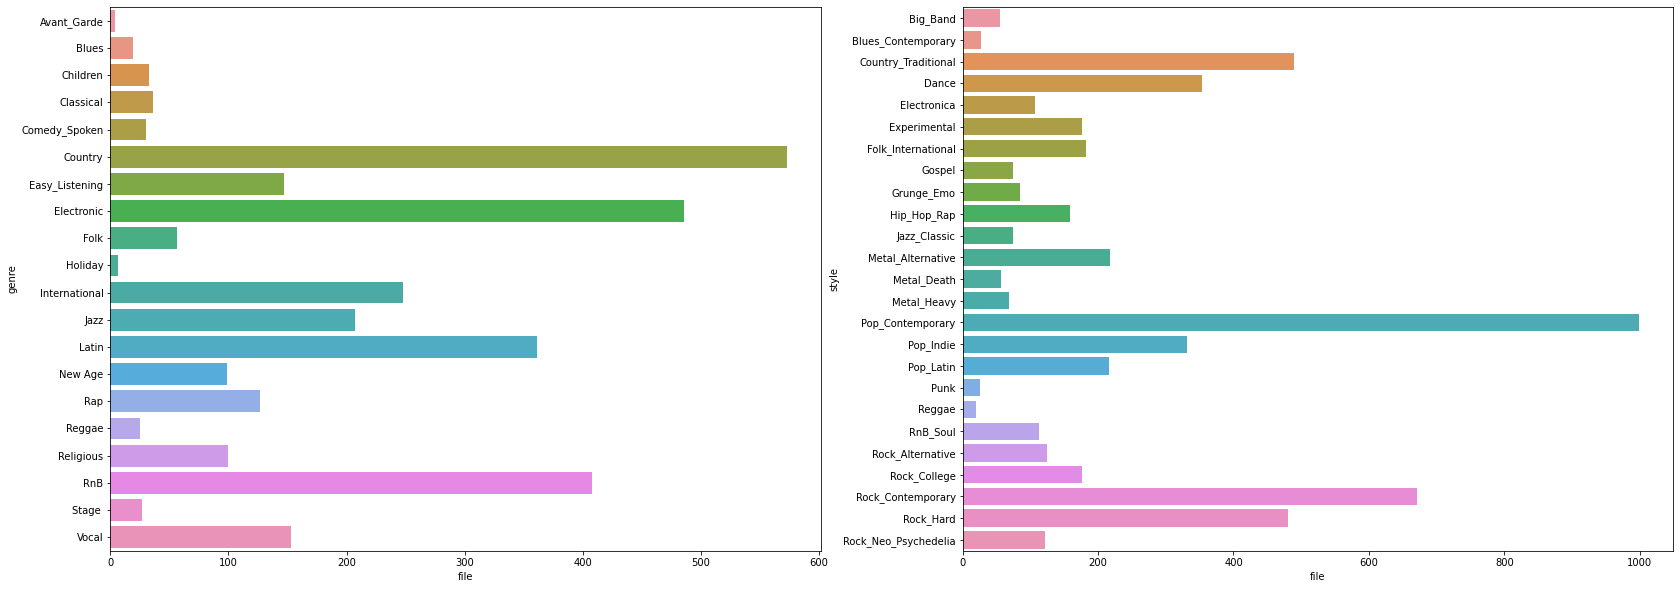

In [36]:
plt.figure(figsize=(28,10))
plt.subplot(1,2,1)
data = df[~df.genre.isin(['-', 'Pop_Rock'])].groupby('genre').count()
sns.barplot(y=data.index, x=data.file)
plt.subplot(1,2,2)
data = df[df['style'] != '-'].groupby('style').count()
sns.barplot(y=data.index, x=data.file)
plt.show()

## customize for training

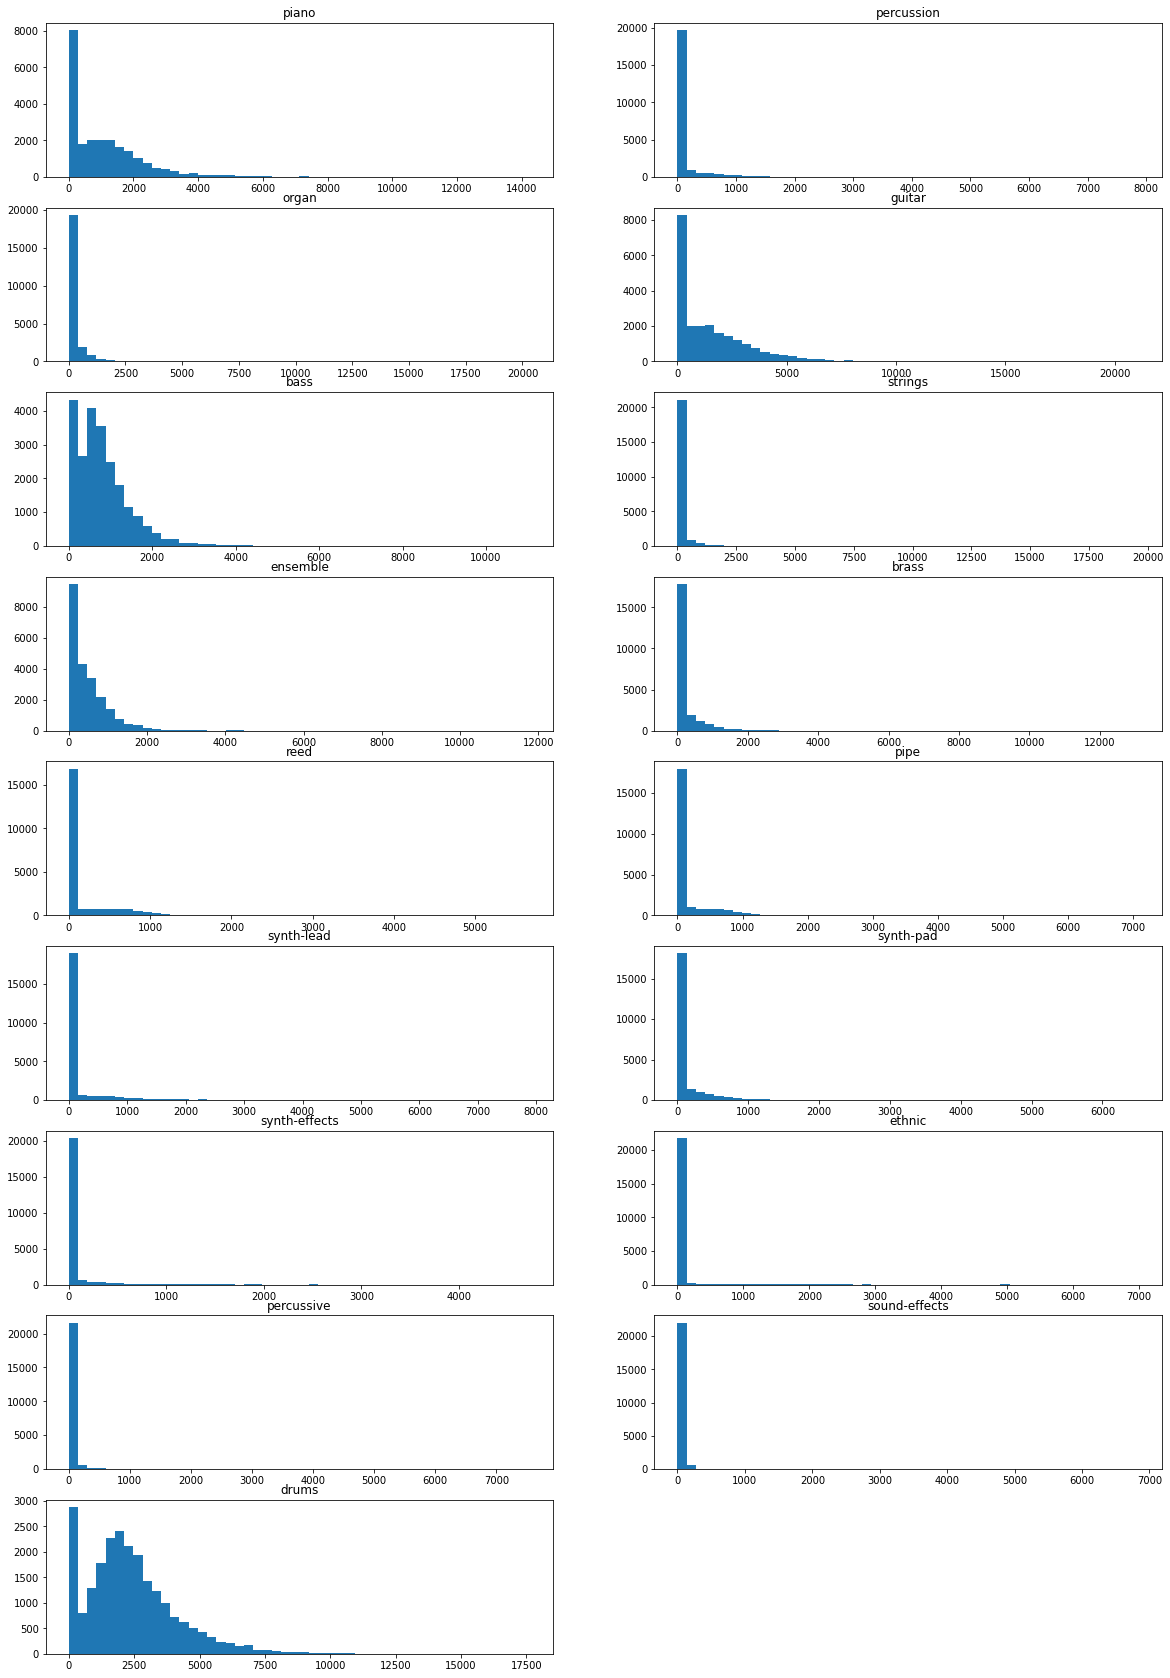

In [13]:
plt.figure(figsize=(20,30))
for i,inst in enumerate(const.instruments):
    plt.subplot(len(const.instruments)//2 + 1, 2, i+1)
    plt.title(inst)
    plt.hist(df[inst], 50)

In [15]:
df2 = df[(df.piano > 0) & (df.guitar > 0) & (df.drums > 0) & (df.bass > 0)]
df2['sum_events'] = df2.progress_apply(lambda x: x['piano'] + x['guitar'] + x['drums'] + x['bass'], axis=1)
df2['piano_frac'] = df2.progress_apply(lambda x: x['piano']/ x['sum_events'], axis=1)
df2['guitar_frac'] = df2.progress_apply(lambda x: x['guitar']/ x['sum_events'], axis=1)
df2['bass_frac'] = df2.progress_apply(lambda x: x['bass']/ x['sum_events'], axis=1)
df2['drums_frac'] = df2.progress_apply(lambda x: x['drums']/ x['sum_events'], axis=1)
df2['avg_event_per_bar'] = df2.progress_apply(lambda x: x['sum_events']/x['n_bar'], axis=1)
print(df2.shape)
df2.head()

  0%|          | 0/10808 [00:00<?, ?it/s]

  0%|          | 0/10808 [00:00<?, ?it/s]

  0%|          | 0/10808 [00:00<?, ?it/s]

  0%|          | 0/10808 [00:00<?, ?it/s]

  0%|          | 0/10808 [00:00<?, ?it/s]

  0%|          | 0/10808 [00:00<?, ?it/s]

(10808, 27)


,file,n_bar,piano,percussion,organ,guitar,bass,strings,ensemble,brass,...,sound-effects,drums,genre,style,sum_events,piano_frac,guitar_frac,bass_frac,drums_frac,avg_event_per_bar
2,4fb43d0e8e8d263a5c97a797d8343a08.mid,405,7954,5133,0,4696,3553,0,0,0,...,0,9507,-,-,25710,0.309374,0.182653,0.138195,0.369778,63.481481
20,5dd4427d17c9f72d41231ac40337f30b.mid,306,1691,0,0,897,810,0,0,0,...,0,1997,Pop_Rock,Pop_Latin,5395,0.313438,0.166265,0.150139,0.370158,17.630719
23,c301629e57f9a052b783601de8c43d45.mid,304,3077,1173,739,3176,2074,0,1017,604,...,0,8252,-,-,16579,0.185596,0.191568,0.125098,0.497738,54.536184
29,9b00e3e07949ddb99638f4cf0c0a914c.mid,292,697,0,1696,3243,1788,0,695,0,...,301,4786,-,-,10514,0.066293,0.308446,0.170059,0.455203,36.006849
33,1a2edb832812beeaab257acf69e2c7f1.mid,291,1830,0,0,11698,1779,0,292,0,...,317,4970,-,-,20277,0.090250,0.576910,0.087735,0.245105,69.680412


In [16]:
# df3 = df2[df2['genre'] != '-']
# print(df3.shape)

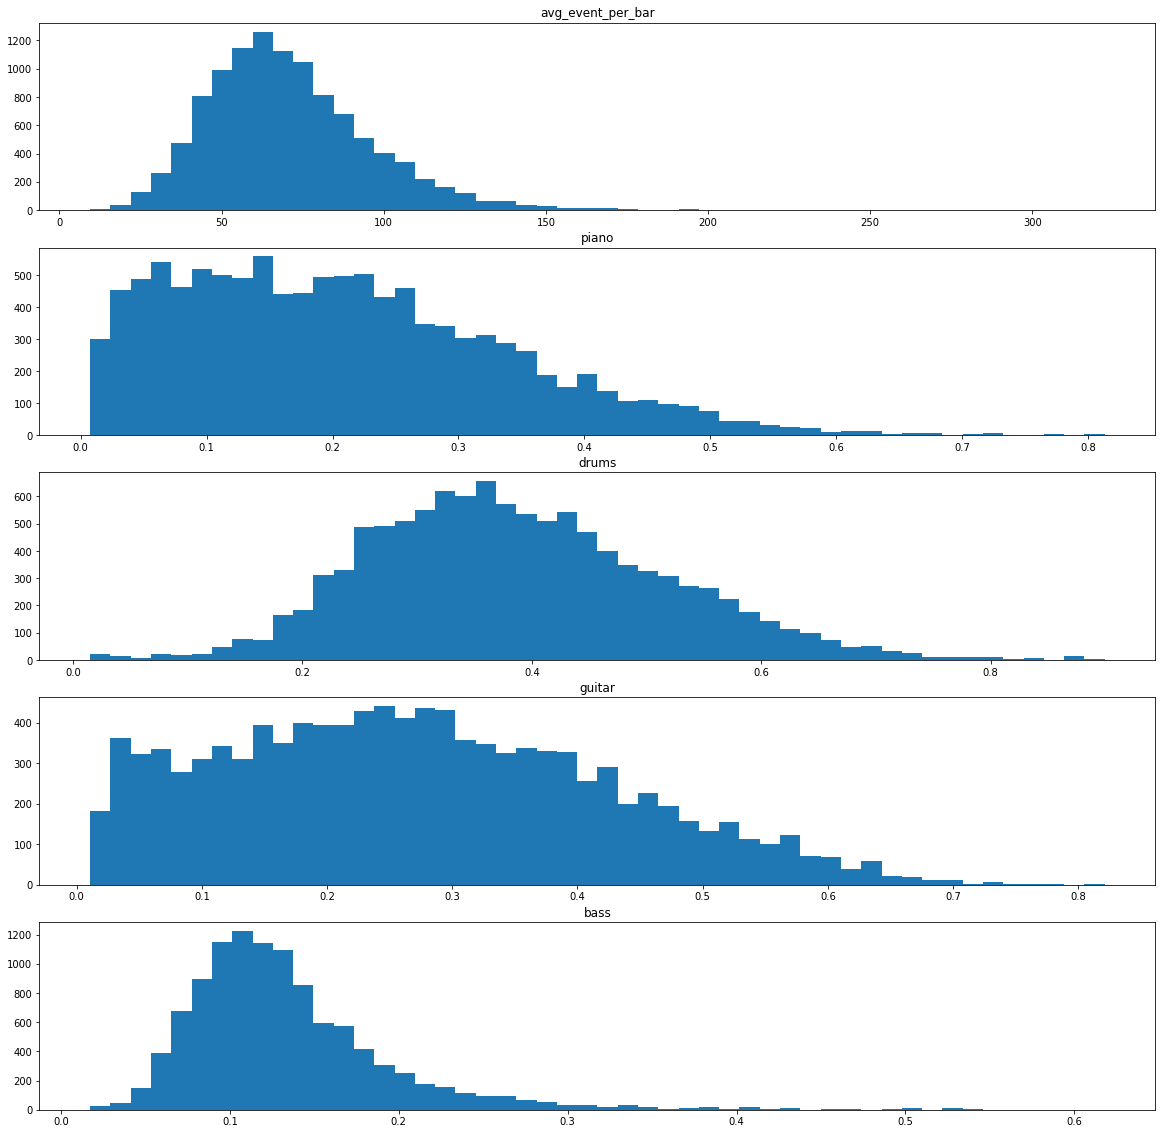

In [17]:
plt.figure(figsize=(20,20))
plt.subplot(5,1,1)
plt.title('avg_event_per_bar')
plt.hist(df2.avg_event_per_bar, 50)
plt.subplot(5,1,2)
plt.title('piano')
plt.hist(df2.piano_frac, 50)
plt.subplot(5,1,3)
plt.title('drums')
plt.hist(df2.drums_frac, 50)
plt.subplot(5,1,4)
plt.title('guitar')
plt.hist(df2.guitar_frac, 50)
plt.subplot(5,1,5)
plt.title('bass')
plt.hist(df2.bass_frac, 50)
plt.show()

In [21]:
df3 = df2[(df2.drums_frac > 0.2) & (df2.piano_frac > 0.2) & (df2.guitar_frac > 0.2)]
df3.shape

(2283, 27)

In [22]:
# df4 = df3[df3.drums_frac > 0.2]
# df4 = df4[~df4.genre.isin([
#     'Avant_Garde', 'Blues', 'Children', 'Classical', 'Stage ', 
#     'New Age', 'Reggae', 'Comedy_Spoken', 'Pop_Rock',
# ])]
# df3 = df3[['file', 'n_bar', 'piano', 'guitar', 'drums']]
# print(df4.shape)
# df4.head()

In [25]:
# plt.figure(figsize=(28,10))
# plt.subplot(1,2,1)
# data = df3.groupby('genre').count()
# sns.barplot(y=data.index, x=data.file)
# plt.subplot(1,2,2)
# data = df3.groupby('style').count()
# sns.barplot(y=data.index, x=data.file)
# plt.show()

In [24]:
files = df3.file.to_list()
pickle.dump(files, open('files.pkl', 'wb'))
len(files)

2283

# e-gmd dataset